# Estimating the Parameters of a Multivariate Skew-Normal Distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from mvem.stats import multivariate_skewnorm as mvsn

## Data

We generate some simple sample data.

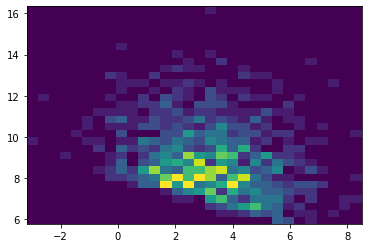

In [2]:
mu = [3, 7]
shape = [[3, -0.2], [-0.2, 6]]
lmbda = [3, 12]
x = mvsn.rvs(mu, shape, lmbda, size=1000)

_ = plt.hist2d(x[:, 0], x[:, 1], bins=30)

## Estimate Parameters

We estimate the maximum likelihood parameters of the skew-normal distribution using an EM algorithm.

Fitted mu: [2.95979724 7.03195626]
Fitted shape: [[ 3.09927812 -0.19325962]
 [-0.19325962  6.31339262]]
Fitted lmbda: [ 2.61963802 10.76120862]


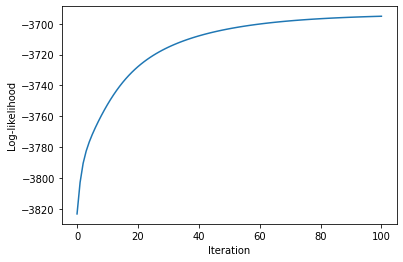

In [3]:
mu_fitted, shape_fitted, lmbda_fitted, loglikelihood = mvsn.fit(x, return_loglike=True, ftol=1e-10)

print("Fitted mu: " + str(mu_fitted))
print("Fitted shape: " + str(shape_fitted))
print("Fitted lmbda: " + str(lmbda_fitted))

plt.plot(loglikelihood)
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.show()

## Model Analysis

We compare a set of percentiles between the empirical and fitted distribution.

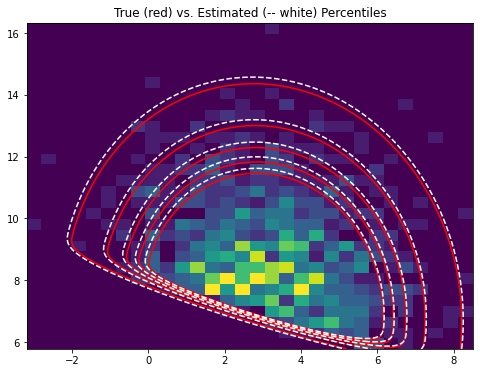

In [4]:
def get_contours(x, model, params):
    # pdf positions
    xmin = np.min(x, axis=0)
    xmax = np.max(x, axis=0)
    X    = np.linspace(xmin[0], xmax[0], 300)
    Y    = np.linspace(xmin[1], xmax[1], 300)
    X, Y = np.meshgrid(X, Y)
    pos  = np.dstack((X, Y))

    # fitted pdf at specified positions
    Z = model.pdf(pos, *params)
    Z = Z / Z.sum()

    # find quantiles
    q = [0.99, 0.95, 0.90, 0.85, 0.80]
    t = np.linspace(0, Z.max(), 1000)
    integral = ((Z >= t[:, None, None]) * Z).sum(axis=(1,2))
    f = scipy.interpolate.interp1d(integral, t)
    t_contours_true = f(q)

    # assure list form
    if len(t_contours_true.shape) == 0:
        t_contours_true = [t_contours_true]
    return X, Y, Z, t_contours_true

X_true, Y_true, Z_true, t_true = get_contours(x, mvsn, (mu, shape, lmbda))
X_fitted, Y_fitted, Z_fitted, t_fitted = get_contours(x, mvsn, (mu_fitted, shape_fitted, lmbda_fitted))

plt.figure(figsize=(8, 6))
plt.hist2d(x[:, 0], x[:, 1], bins=30)
path = plt.contour(X_true, Y_true, Z_true, t_true, colors="red")
path = plt.contour(X_fitted, Y_fitted, Z_fitted, t_fitted, colors="white", linestyles="dashed")
plt.title("True (red) vs. Estimated (-- white) Percentiles")
plt.show()